In [1]:
# Chạy ô này ĐẦU TIÊN và DUY NHẤT
# Sau đó vào Runtime -> Restart Session và thực hiện lần lượt các code cells tiếp theo
!pip install kaggle transformers huggingface_hub nltk spacy gensim
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 129.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
# Cài đặt Kaggle API key
# 1. Tải lên tệp kaggle.json của bạn
from google.colab import files
files.upload()

# 2. Di chuyển tệp vào đúng thư mục và cấp quyền
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\nCấu hình Kaggle API hoàn tất.")

Saving kaggle.json to kaggle.json

Cấu hình Kaggle API hoàn tất.


In [2]:
from google.colab import userdata
import huggingface_hub

try:
    hf_token = userdata.get('HF_TOKEN')
    huggingface_hub.login(token=hf_token)
    print("Đăng nhập Hugging Face thành công!")
except Exception as e:
    print(f"Lỗi khi đăng nhập Hugging Face: {e}")
    print("Vui lòng kiểm tra lại xem bạn đã lưu token trong Colab Secrets chưa.")

Đăng nhập Hugging Face thành công!


In [3]:
# Tải bộ dữ liệu từ Kaggle
!kaggle datasets download -d denizbilginn/google-maps-restaurant-reviews

# Giải nén tệp zip
!unzip -o google-maps-restaurant-reviews.zip

print("\nTải và giải nén dữ liệu thành công.")

Dataset URL: https://www.kaggle.com/datasets/denizbilginn/google-maps-restaurant-reviews
License(s): ODbL-1.0
 97% 634M/657M [00:07<00:00, 71.3MB/s]
100% 657M/657M [00:07<00:00, 97.5MB/s]
Archive:  google-maps-restaurant-reviews.zip
  inflating: dataset/dataset/indoor_atmosphere/abidin_tantuni_enes_ozturk.png  
  inflating: dataset/dataset/indoor_atmosphere/abidin_tantuni_erdal_dalgalar.png  
  inflating: dataset/dataset/indoor_atmosphere/abidin_tantuni_nezahat_arslan.png  
  inflating: dataset/dataset/indoor_atmosphere/abidin_tantuni_nihat_karabiber.png  
  inflating: dataset/dataset/indoor_atmosphere/ahsap_iskender_ersin_kocabaldir.png  
  inflating: dataset/dataset/indoor_atmosphere/ahsap_iskender_omer_ata.png  
  inflating: dataset/dataset/indoor_atmosphere/ahsap_iskender_suat_ozdogan.png  
  inflating: dataset/dataset/indoor_atmosphere/akpinar_restaurant_selim_cukur.png  
  inflating: dataset/dataset/indoor_atmosphere/akpinar_restaurant_sibel_sarayli.png  
  inflating: dataset/dat

In [4]:
import pandas as pd
import re

# Tương ứng với: Preprocess: Load into pandas DataFrame
df = pd.read_csv('reviews.csv')
print(f"Dữ liệu ban đầu có {len(df)} hàng.")

# Tương ứng với: Preprocess: Handle missing values
df.dropna(subset=['text'], inplace=True)
print(f"Số hàng sau khi loại bỏ giá trị thiếu: {len(df)}")

# Tương ứng với: Preprocess: standardize formats (remove duplicates)
num_duplicates_before = df.duplicated(subset=['text']).sum()
df.drop_duplicates(subset=['text'], inplace=True, keep='first')
print(f"Đã loại bỏ {num_duplicates_before} hàng trùng lặp. Số hàng còn lại: {len(df)}")

# Tương ứng với: Clean noise & standardize formats (lowercase)
def clean_text(text):
    text = str(text).lower()  # Chuyển chữ thường
    text = re.sub(r'[^a-z\s]', '', text) # Loại bỏ dấu câu, số...
    return text

df['text_clean'] = df['text'].apply(clean_text)
print("\nĐã hoàn tất tiền xử lý văn bản.")
print("5 dòng đầu tiên sau khi làm sạch:")
print(df[['text', 'text_clean']].head())

Dữ liệu ban đầu có 1100 hàng.
Số hàng sau khi loại bỏ giá trị thiếu: 1100
Đã loại bỏ 12 hàng trùng lặp. Số hàng còn lại: 1088

Đã hoàn tất tiền xử lý văn bản.
5 dòng đầu tiên sau khi làm sạch:
                                                text  \
0  We went to Marmaris with my wife for a holiday...   
1  During my holiday in Marmaris we ate here to f...   
2  Prices are very affordable. The menu in the ph...   
3  Turkey's cheapest artisan restaurant and its f...   
4  I don't know what you will look for in terms o...   

                                          text_clean  
0  we went to marmaris with my wife for a holiday...  
1  during my holiday in marmaris we ate here to f...  
2  prices are very affordable the menu in the pho...  
3  turkeys cheapest artisan restaurant and its fo...  
4  i dont know what you will look for in terms of...  


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Tương ứng với: Document: Jupyter notebook eda.ipynb
print("--- Báo cáo Phân tích Dữ liệu Khám phá (EDA) ---")
print("\nThông tin chung của DataFrame:")
df.info()

--- Báo cáo Phân tích Dữ liệu Khám phá (EDA) ---

Thông tin chung của DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 1088 entries, 0 to 1099
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_name    1088 non-null   object
 1   author_name      1088 non-null   object
 2   text             1088 non-null   object
 3   photo            1088 non-null   object
 4   rating           1088 non-null   int64 
 5   rating_category  1088 non-null   object
 6   text_clean       1088 non-null   object
dtypes: int64(1), object(6)
memory usage: 68.0+ KB


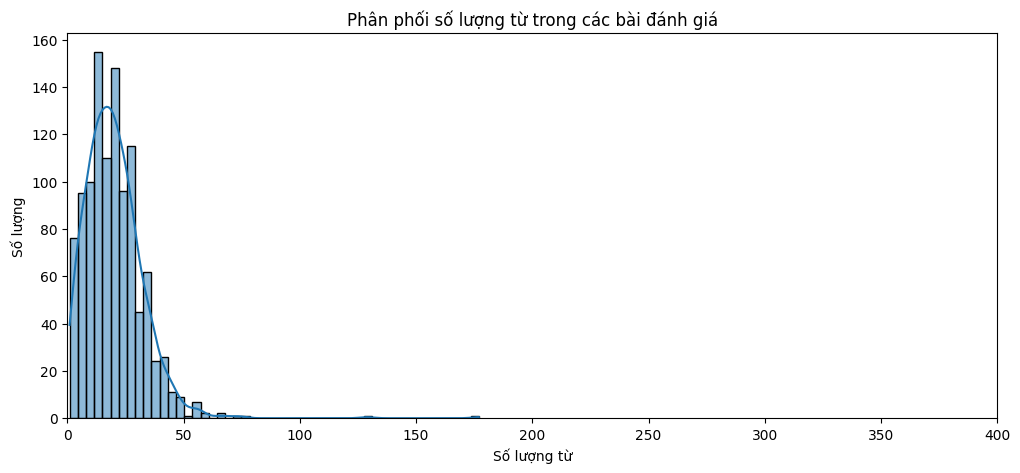

/tmp/ipython-input-2399928980.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


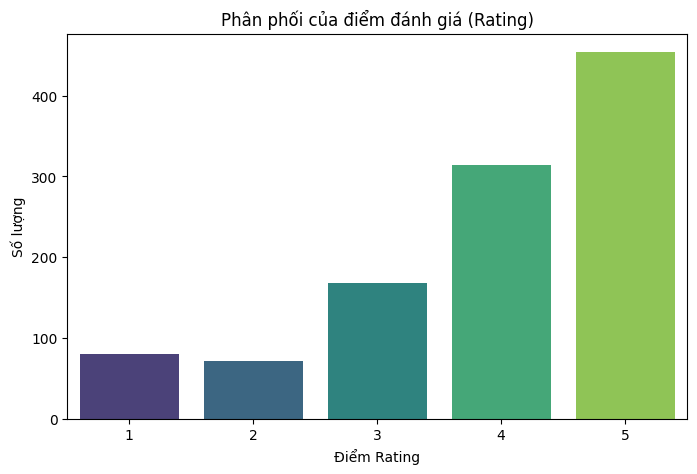

In [6]:
# Phân tích độ dài review (số từ)
df['word_count'] = df['text_clean'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 5))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Phân phối số lượng từ trong các bài đánh giá')
plt.xlabel('Số lượng từ')
plt.ylabel('Số lượng')
plt.xlim(0, 400)
plt.show()

# Phân phối điểm rating
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Phân phối của điểm đánh giá (Rating)')
plt.xlabel('Điểm Rating')
plt.ylabel('Số lượng')
plt.show()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


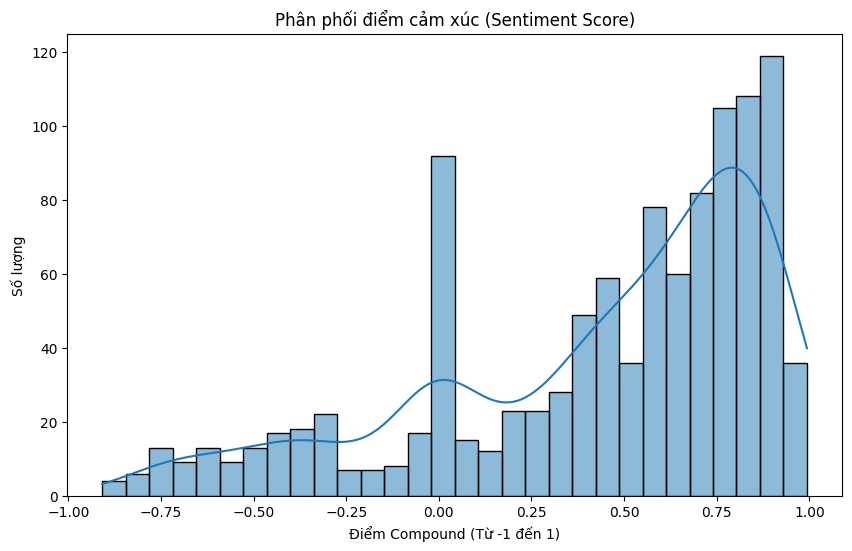

In [8]:
# Sửa lỗi: Thêm 2 dòng này để tải lại tài nguyên NLTK
import nltk
nltk.download('vader_lexicon')

# --- Phần code cũ của bạn vẫn giữ nguyên ---
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt

# Khởi tạo VADER (bây giờ sẽ không lỗi nữa)
analyzer = SentimentIntensityAnalyzer()

# Lấy điểm compound sentiment
df['sentiment_score'] = df['text'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

# Vẽ biểu đồ phân phối điểm sentiment
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment_score'], bins=30, kde=True)
plt.title('Phân phối điểm cảm xúc (Sentiment Score)')
plt.xlabel('Điểm Compound (Từ -1 đến 1)')
plt.ylabel('Số lượng')
plt.show()

/tmp/ipython-input-3434178306.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=top_df, ax=ax, palette=palette)
/tmp/ipython-input-3434178306.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=top_df, ax=ax, palette=palette)


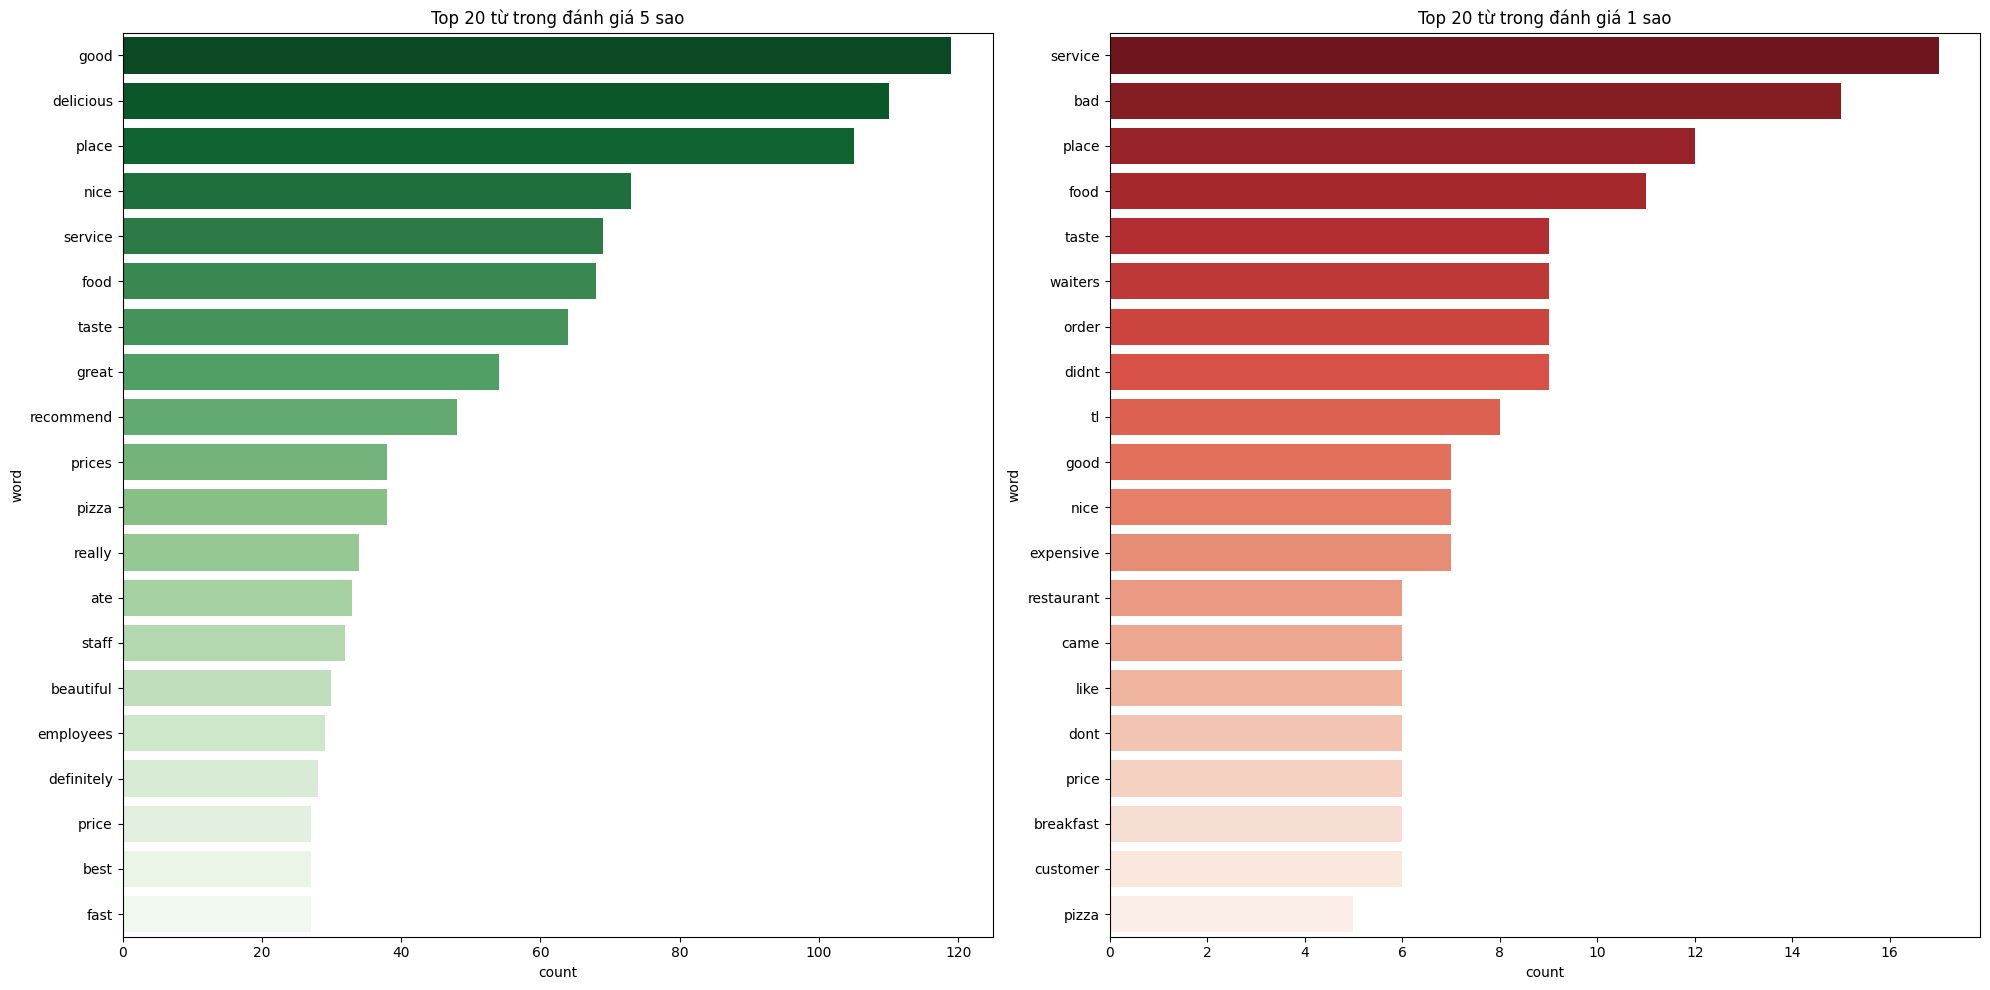

In [9]:
def plot_top_words(corpus, title, palette, ax):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = sorted([(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()], key=lambda x: x[1], reverse=True)
    top_df = pd.DataFrame(words_freq[:20], columns=['word', 'count'])
    sns.barplot(x='count', y='word', data=top_df, ax=ax, palette=palette)
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_top_words(df[df['rating'] == 5]['text_clean'], 'Top 20 từ trong đánh giá 5 sao', 'Greens_r', axes[0])
plot_top_words(df[df['rating'] == 1]['text_clean'], 'Top 20 từ trong đánh giá 1 sao', 'Reds_r', axes[1])
plt.tight_layout()
plt.show()

In [10]:
url_pattern = r'(https|http|www)[^\s]+'
df['has_url'] = df['text'].str.contains(url_pattern, case=False, na=False)
num_reviews_with_url = df['has_url'].sum()

print(f"Phát hiện được {num_reviews_with_url} bài đánh giá có chứa URL (dấu hiệu của quảng cáo).")

Phát hiện được 0 bài đánh giá có chứa URL (dấu hiệu của quảng cáo).


/tmp/ipython-input-2281128945.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['has_url'] = df['text'].str.contains(url_pattern, case=False, na=False)
